In [1]:
from preprocessing import preprocess_flowdata, preprocess_graph
from dataset import WaterFlowDataSet
from model import Model
import torch
#from torch_geometric.nn import GCNConv
#import torch.nn as nn

In [2]:
from preprocessing import preprocess_flowdata, preprocess_graph

In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import euclidean
import torch
from sklearn.model_selection import train_test_split
from eda import plotGraph

In [2]:
FLOWDATA_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\FlowData_for_SubsetGraph_12_with_7SensoredPipes.csv"
SUBSETGRAPH_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\SubsetGraph_12_with_7SensoredPipes.csv"

In [3]:
df_node_features, df_node_features_strata = preprocess_flowdata(FLOWDATA_PATH)
edge_indices, edge_weights = preprocess_graph(SUBSETGRAPH_PATH)

In [4]:
train_dataset = WaterFlowDataSet(df_node_features[0], df_node_features_strata[0], edge_indices, edge_weights)
val_dataset = WaterFlowDataSet(df_node_features[1], df_node_features_strata[1], edge_indices, edge_weights)
test_dataset = WaterFlowDataSet(df_node_features[2], df_node_features_strata[2], edge_indices, edge_weights)

In [5]:
WIN_SIZE = 9

model = Model(input_channels = WIN_SIZE, hidden_channels = WIN_SIZE, output_channels = WIN_SIZE)

optimiser = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [6]:
def train(model, optimiser, data):
    model.train()
    optimiser.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.mask], data.y[data.mask].squeeze()) 
    loss.backward()
    optimiser.step()
    return loss.item()

def xtrain(model, optimiser, loader):
    model.train()
    total_loss = 0

    for batch in loader:
        optimiser.zero_grad()
        out = model(batch.x, batch.edge_index) 
        loss = criterion(out[batch.mask], batch.y[batch.mask].squeeze())
        loss.backward()
        optimiser.step()
        total_loss += loss.item() * batch.num_graphs 

    return total_loss / len(loader.dataset)

def validate (model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index) 
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask].squeeze())
    return val_loss.item()

def xval(model, loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index) 
            loss = criterion(out[batch.mask], batch.y[batch.mask].squeeze())
            total_loss += loss.item() * batch.num_graphs 
    
    return total_loss / len(loader.dataset)


In [7]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [13]:
from torch_geometric.loader import DataLoader

NB_EPOCHS = 100
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

train_loss = []
val_loss = []

for epoch in range(NB_EPOCHS):
    epoch_train_loss = xtrain(model, optimiser, train_loader)
    epoch_val_loss = xval(model, train_loader)
    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Val Loss: {epoch_val_loss}")

Epoch 1, Train Loss: 0.5552202037402562, Val Loss: 0.5661088929071532
Epoch 2, Train Loss: 0.5651657705778604, Val Loss: 0.5674735091544769
Epoch 3, Train Loss: 0.5659665065807301, Val Loss: 0.5566579670041472
Epoch 4, Train Loss: 0.5361832946866423, Val Loss: 0.5633165649660341
Epoch 5, Train Loss: 0.5769408391072199, Val Loss: 0.5398045339427151
Epoch 6, Train Loss: 0.5350774457821479, Val Loss: 0.5566365424093309
Epoch 7, Train Loss: 0.5540125844897804, Val Loss: 0.5132957362866664
Epoch 8, Train Loss: 0.5658944075579172, Val Loss: 0.5451874716596289
Epoch 9, Train Loss: 0.5657870690901201, Val Loss: 0.5530340815638448
Epoch 10, Train Loss: 0.5459145166716732, Val Loss: 0.5788365369969672
Epoch 11, Train Loss: 0.5464679489096442, Val Loss: 0.5251477007027511
Epoch 12, Train Loss: 0.5563742407075651, Val Loss: 0.5122618537682754
Epoch 13, Train Loss: 0.5727039988224323, Val Loss: 0.5331317274780064
Epoch 14, Train Loss: 0.5323853433787168, Val Loss: 0.5782240753645426
Epoch 15, Train

In [49]:
a = train_dataset[0]
print(a)

Data(x=[6, 12], edge_index=[2, 15], y=[6, 12], mask=[6, 12], edge_weight=[15])


In [46]:
print("Number of graphs:", len(train_dataset))

# Size of first graph
print("First graph:", train_dataset[0])
print("Number of nodes in first graph:", train_dataset[0].num_nodes)
print("Number of edges in first graph:", train_dataset[0].num_edges)

Number of graphs: 224
First graph: Data(x=[6, 12], edge_index=[2, 15], y=[6, 12], mask=[6, 12], edge_weight=[15])
Number of nodes in first graph: 6
Number of edges in first graph: 15


In [45]:
for batch_idx, batch in enumerate(train_loader):
    print(f"Batch {batch_idx+1}")
    print("Batch type:", type(batch))
    
    # batch.x, batch.y, batch.mask, etc. are accessible
    print("x shape:", batch.x.shape)
    print("y shape:", batch.y.shape)
    print("mask shape:", batch.mask.shape)
    print("edge_index shape:", batch.edge_index.shape)
    
    # Show first 2 nodes/features
    print("First 2 x nodes:", batch.x[:2])
    print("First 2 y nodes:", batch.y[:2])
    
    break  # just inspect the first batch


Batch 1
Batch type: <class 'abc.DataBatch'>
x shape: torch.Size([192, 12])
y shape: torch.Size([192, 12])
mask shape: torch.Size([192, 12])
edge_index shape: torch.Size([2, 480])
First 2 x nodes: tensor([[1.6444, 1.6292, 1.5309, 1.6802, 1.6422, 1.6761, 1.8335, 1.7027, 1.5847,
         1.6358, 1.5892, 1.5404],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]])
First 2 y nodes: tensor([[1.6444, 1.6292, 1.5309, 1.6802, 1.6422, 1.6761, 1.8335, 1.7027, 1.5847,
         1.6358, 1.5892, 1.5404],
        [1.3408, 1.4191, 1.3437, 1.4377, 1.4110, 1.2270, 1.1973, 1.4083, 1.0176,
         1.0723, 0.9598, 1.1872]])


In [9]:


train_loss = []
val_loss = []

for epoch in range(300):
    epoch_losses = []  # store batch losses for this epoch

    for data in train_dataset:
        batch_loss = train(model, optimiser, data)  # train on this batch
        epoch_losses.append(batch_loss)

    # average loss for the epoch
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    train_loss.append(avg_epoch_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_epoch_loss}")


Epoch 1, Train Loss: 0.6134712989960163
Epoch 2, Train Loss: 0.5544596533580481
Epoch 3, Train Loss: 0.6068578154124654
Epoch 4, Train Loss: 0.6149785620871046
Epoch 5, Train Loss: 0.6299671295518248
Epoch 6, Train Loss: 0.6537945124606607
Epoch 7, Train Loss: 0.6194361531401787
Epoch 8, Train Loss: 0.6308424066282696
Epoch 9, Train Loss: 0.6188919863469802
Epoch 10, Train Loss: 0.604394683101858
Epoch 11, Train Loss: 0.6510679295103757
Epoch 12, Train Loss: 0.6097603486056099
Epoch 13, Train Loss: 0.6314009085548965
Epoch 14, Train Loss: 0.5512031402552736
Epoch 15, Train Loss: 0.6007377789099957
Epoch 16, Train Loss: 0.6098051115564725
Epoch 17, Train Loss: 0.597695167799919
Epoch 18, Train Loss: 0.6311675441215662
Epoch 19, Train Loss: 0.6266509485427817
Epoch 20, Train Loss: 0.5744976044343375
Epoch 21, Train Loss: 0.6557485341149764
Epoch 22, Train Loss: 0.5956018966357838
Epoch 23, Train Loss: 0.6118356086020128
Epoch 24, Train Loss: 0.5934343505087871
Epoch 25, Train Loss: 0.593

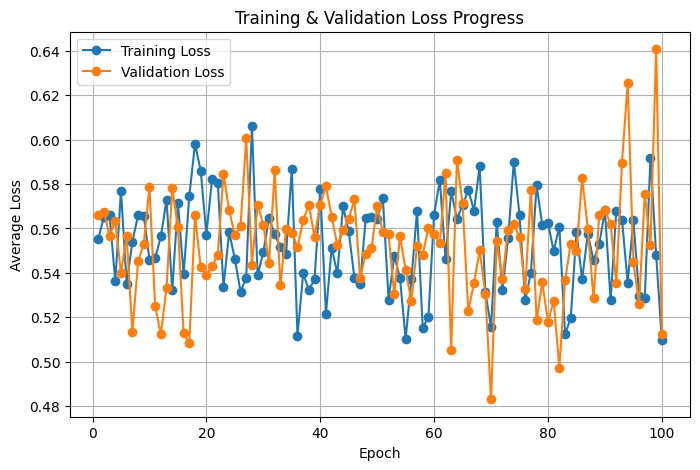

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(range(1, NB_EPOCHS + 1), train_loss, marker='o', label='Training Loss')
plt.plot(range(1, NB_EPOCHS + 1), val_loss, marker='o', label='Validation Loss')

plt.title('Training & Validation Loss Progress')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')

plt.grid(True)
plt.legend()
plt.show()

In [10]:
print(len(train_loss), len(val_loss))

600 0


In [28]:
train_loss = []
val_loss = []

for epoch in range(1):
    train_loss.append(train(model, optimiser, train_dataset))
    print(train_loss[-1])
    #val_loss.append(validate(model, test_dataset)) 

AttributeError: 'WaterFlowDataSet' object has no attribute 'x'

In [21]:
print(train_loss)

[28.961515426635742, 18.475557327270508, 17.514236450195312, 18.35321617126465, 16.56226921081543, 18.837583541870117, 18.80560302734375, 22.15268898010254, 16.617921829223633, 18.39676284790039]
